<b>Tamanho dataset</b>: 6Gb
<br>
<b>Conteúdo:</b> Colisões de Janeiro de 2001 até outubro de 2020 da California Highway Patrol 
<br>


<b>Objetivo do notebook:</b>
<br>-Realizar conexão com banco de dados
<br>-Treinamento de queries SQL
<br>-Treinamento de ETL
<br>-Aplicar os conhecimentos sobre dados obtidos nos últimos meses


<b>Perguntas para serem respondidas:</b>
<br>
-Quais são os meses com mais acidentes?
<br>
-Quais são as horas com mais acidentes?
<br>
-Horário de acidentes com vítimas e sem vítimas varia?
<br>
-Quais são os principais motivos dos acidentes?
<br>
-Quais são as marcas de carros envolvidas em mais acidentes?
<br>
-Qual é a média do ano dos carros envolvidos em acidentes?


<b>Composição do dataset:</b>
<br>----------------------------<br>
<b>Collisions:</b> Contém informações sobre as colisões, onde aconteceram, quais veículos estavam envolvidos.
<br><b>Total de Linhas:</b> Aprox. 9M
<br>----------------------------<br>
<b>parties:</b> Contém informações sobre os grupos de pessoas envolvidas na colisão, incluindo idade, sexo e sobriedade.
<br><b>Total de Linhas:</b> Aprox. 18M
<br>----------------------------<br>
<b>victims:</b> contém informações sobre os ferimentos de pessoas específicas envolvidas na colisão.
<br><b>Total de Linhas:</b> Aprox. 9M

<br><a href="https://www.kaggle.com/alexgude/california-traffic-collision-data-from-switrs">Dataset Disponível Aqui</a>

In [1]:
import pandas as pd
import sqlite3
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import timeit

In [2]:
con = sqlite3.connect("switrs.sqlite")
cur = con.cursor()

In [3]:
query_collisions = "SELECT * FROM collisions LIMIT 1000"
query_parties = "SELECT * FROM parties LIMIT 1000"
victims = "SELECT * FROM victims LIMIT 1000"

In [4]:
dataset_collisions = pd.read_sql_query(query_collisions, con)
dataset_parties = pd.read_sql_query(query_parties, con)

In [5]:
dataset_parties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            1000 non-null   int64  
 1   case_id                       1000 non-null   object 
 2   party_number                  1000 non-null   int64  
 3   party_type                    1000 non-null   object 
 4   at_fault                      1000 non-null   int64  
 5   party_sex                     895 non-null    object 
 6   party_age                     890 non-null    float64
 7   party_sobriety                986 non-null    object 
 8   party_drug_physical           118 non-null    object 
 9   direction_of_travel           989 non-null    object 
 10  party_safety_equipment_1      867 non-null    object 
 11  party_safety_equipment_2      848 non-null    object 
 12  financial_responsibility      932 non-null    object 
 13  haza

In [6]:
dataset_collisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 74 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   case_id                          1000 non-null   object 
 1   jurisdiction                     1000 non-null   int64  
 2   officer_id                       999 non-null    object 
 3   reporting_district               248 non-null    object 
 4   chp_shift                        1000 non-null   object 
 5   population                       1000 non-null   object 
 6   county_city_location             1000 non-null   object 
 7   special_condition                1000 non-null   object 
 8   beat_type                        1000 non-null   object 
 9   chp_beat_type                    1000 non-null   object 
 10  city_division_lapd               56 non-null     object 
 11  chp_beat_class                   1000 non-null   object 
 12  beat_number          

In [7]:
new_query_collisions = """SELECT case_id, population, special_condition,weather_1, location_type, collision_severity,
                        killed_victims, injured_victims, party_count, primary_collision_factor, type_of_collision,
                        road_condition_1, severe_injury_count,pedestrian_killed_count, pedestrian_injured_count,bicyclist_killed_count,
                        bicyclist_injured_count, motorcyclist_killed_count, motorcyclist_injured_count, collision_date, collision_time,
                        alcohol_involved, motor_vehicle_involved_with 
                        FROM collisions 
                        WHERE (collision_time IS NOT NULL) and (collision_date IS NOT NULL)"""

In [8]:
starttime = timeit.default_timer()
df_query_collisions = pd.read_sql_query(new_query_collisions, con)
endtime = timeit.default_timer()
tempototal = round((endtime - starttime),2)
print(f"Tempo total de processamento: {tempototal}s")

Tempo total de processamento: 276.41s


In [9]:
df_col = df_query_collisions.copy()

In [10]:
#df_col[["collision_time", "collision_date", "killed_victims"]].fillna("none", inplace=True)

In [11]:
def retorna_dia_da_semana(x):
    dias_da_semana = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    dia = x.weekday()
    return dias_da_semana[dia]

def get_morte(x):
    if x > 0:
        return "Acidente com morte"
    elif x == 0:
        return "Acidente sem morte"
    else:
        return "Indefinido"

In [12]:
#df_col = df_col[(df_col["collision_time"]!="none") & (df_col["collision_time"]!=None) & (df_col["collision_date"]!="none") & (df_col["killed_victims"]!="none")]

In [14]:
df_col["collision_date_strp"] = df_col["collision_date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df_col["ano"] = df_col["collision_date"].apply(lambda x: x.split("-")[0])
df_col["dia_da_semana"] = df_col["collision_date_strp"].apply(lambda x: retorna_dia_da_semana(x))
df_col["morte_envolvida"] = df_col["killed_victims"].apply(lambda x: get_morte(x))
df_col["hora_colisao_int"] = df_col["collision_time"].apply(lambda x: x.split(":")[0])

In [15]:
df_col["hora_colisao_int"] = df_col["hora_colisao_int"].astype(int)

In [16]:
df_col["mes"] = df_col["collision_date_strp"].apply(lambda x: x.month)

In [17]:
mes_acidentes = df_col["mes"].value_counts().sort_values(ascending=False).reset_index()
mes_acidentes.columns = ["mes", "quantidade"]
mes_acidentes["mes"] = mes_acidentes["mes"].astype(str)

meses = {"1":"Jan", "2":"Fev", "3":"Mar", "4":"Abr", "5":"Mai", 
         "6":"Jun", "7":"Jul", "8":"Ago", "9":"Set","10":"Out","11":"Nov","12":"Dez"}

mes_acidentes["mes"] = mes_acidentes["mes"].apply(lambda x: meses[x])

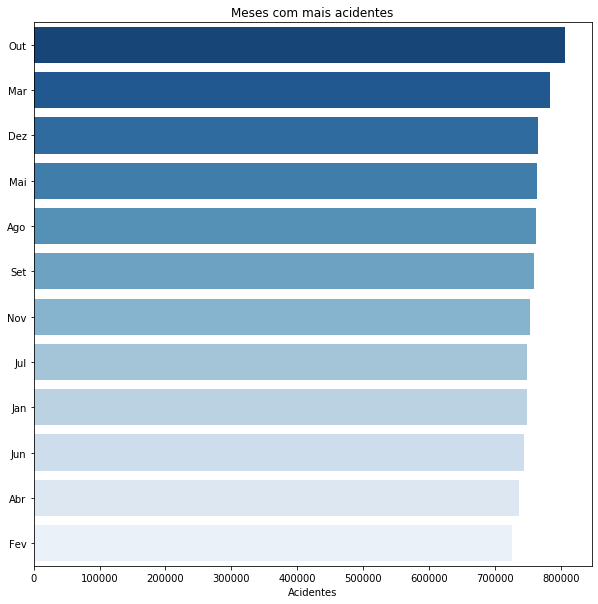

In [18]:
plt.figure(figsize=(10,10))
sns.barplot(y="mes", x="quantidade", data=mes_acidentes, palette="Blues_r")
plt.title("Meses com mais acidentes")
plt.ylabel(None)
plt.xlabel("Acidentes");

In [19]:
data_minima = min(df_col["collision_date_strp"]).date()
data_maxima = max(df_col["collision_date_strp"]).date()
max_vitimas_mortas = max(df_col["killed_victims"])
max_vitimas_feridas = max(df_col["injured_victims"])
dia_max_vitimas = df_col[df_col["killed_victims"]==max_vitimas_mortas]

In [20]:
print(f"Total de colisões: {df_col['case_id'].nunique()}")
print(f"Intervalo de datas: De {data_minima} até {data_maxima}")
print(f"Máximo de vítimas mortas em um único acidente: {max_vitimas_mortas}")
print(f"Máximo de vítimas feridas em um único acidente: {max_vitimas_feridas}")

Total de colisões: 9092753
Intervalo de datas: De 2001-01-01 até 2020-10-22
Máximo de vítimas mortas em um único acidente: 13.0
Máximo de vítimas feridas em um único acidente: 105.0


In [21]:
dia_max_vitimas

,case_id,population,special_condition,weather_1,location_type,collision_severity,killed_victims,injured_victims,party_count,primary_collision_factor,...,collision_date,collision_time,alcohol_involved,motor_vehicle_involved_with,collision_date_strp,ano,dia_da_semana,morte_envolvida,hora_colisao_int,mes
4696844,90585680,4,0,clear,None,fatal,13.0,31.0,2.0,vehicle code violation,...,2016-10-23,05:16:00,NaN,other motor vehicle,2016-10-23,2016,Sunday,Acidente com morte,5,10


Text(0, 0.5, 'Acidentes')

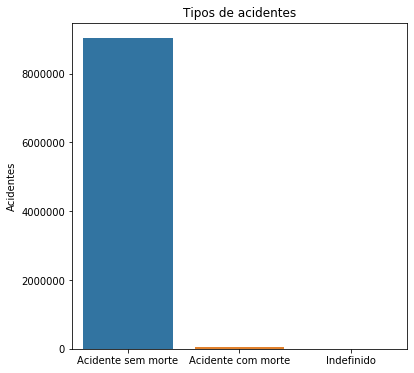

In [22]:
plt.figure(figsize=(6,6))
sns.countplot(x="morte_envolvida", data=df_col)
plt.title("Tipos de acidentes")
plt.xlabel(None);
plt.ylabel("Acidentes")

<Figure size 360x360 with 0 Axes>

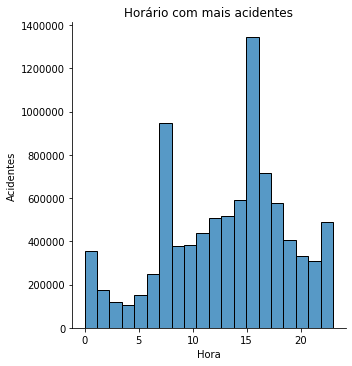

In [23]:
plt.figure(figsize=(5,5))
sns.displot(df_col, x="hora_colisao_int", bins=20)
plt.title("Horário com mais acidentes")
plt.ylabel("Acidentes")
plt.xlabel("Hora");

In [24]:
df_mortes = df_col[df_col["killed_victims"]>0]
df_sem_mortes = df_col[df_col["killed_victims"]==0]

<Figure size 360x360 with 0 Axes>

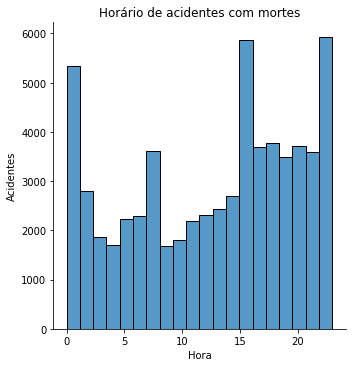

In [25]:
plt.figure(figsize=(5,5));
sns.displot(df_mortes, x="hora_colisao_int", bins=20);
plt.title("Horário de acidentes com mortes")
plt.ylabel("Acidentes")
plt.xlabel("Hora");

<Figure size 360x360 with 0 Axes>

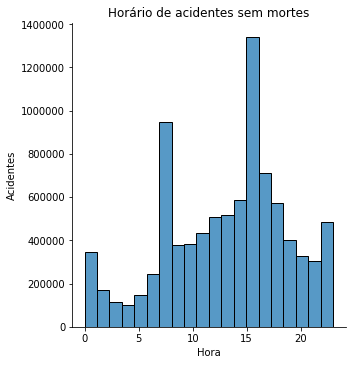

In [26]:
plt.figure(figsize=(5,5))
sns.displot(df_sem_mortes, x="hora_colisao_int", bins=20);
plt.title("Horário de acidentes sem mortes")
plt.xlabel("Hora")
plt.ylabel("Acidentes");

In [27]:
df_kill = df_col[["killed_victims", "injured_victims", "ano"]].groupby("ano").count().reset_index()

(0, 554291.4)

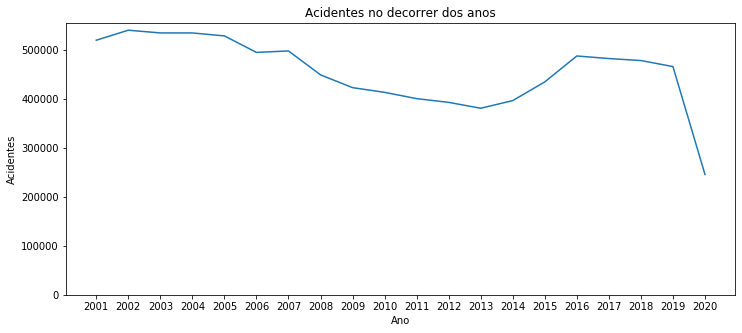

In [28]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df_kill, x="ano", y="killed_victims")
plt.title("Acidentes no decorrer dos anos")
plt.ylabel("Acidentes")
plt.xlabel("Ano")
plt.ylim(0)

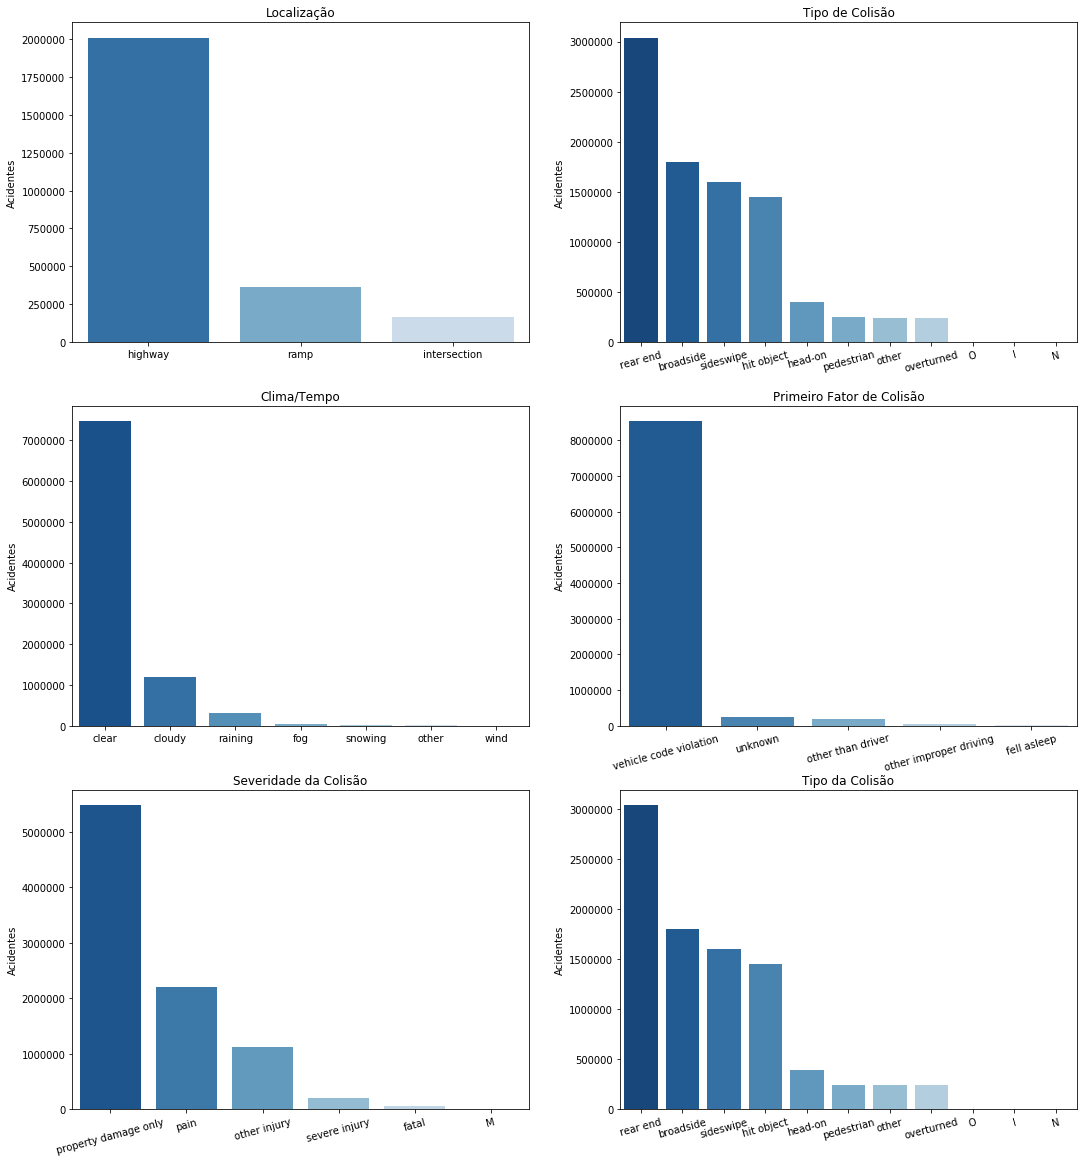

In [29]:
fig, ax = plt.subplots(3,2, figsize=(18,20))
palette = "Blues_r"
y_label = "Acidentes"
x_label = None
labelrotation = 15

ax[0,0] = sns.countplot(x='location_type',data=df_col, ax=ax[0,0],palette=palette,
                        order=df_col["location_type"].value_counts().index)
ax[0,0].set_title("Localização")
ax[0,0].set_ylabel(y_label)
ax[0,0].set_xlabel(x_label)


ax[0,1] = sns.countplot(x='type_of_collision',data=df_col, ax=ax[0,1],palette=palette,
                        order=df_col["type_of_collision"].value_counts().index)
ax[0,1].set_title("Tipo de Colisão")
ax[0,1].set_ylabel(y_label)
ax[0,1].set_xlabel(x_label)
ax[0,1].tick_params(axis="x", labelrotation=labelrotation )


ax[1,0] = sns.countplot(x='weather_1',data=df_col, ax=ax[1,0],palette=palette,
                        order=df_col["weather_1"].value_counts().index)
ax[1,0].set_title("Clima/Tempo")
ax[1,0].set_ylabel(y_label)
ax[1,0].set_xlabel(x_label)


ax[1,1] = sns.countplot(x='primary_collision_factor',data=df_col, ax=ax[1,1],palette=palette,
                        order=df_col["primary_collision_factor"].value_counts().index,)
ax[1,1].set_title("Primeiro Fator de Colisão")
ax[1,1].set_ylabel(y_label)
ax[1,1].set_xlabel(x_label)
ax[1,1].tick_params(axis="x", labelrotation=labelrotation )


ax[2,0] = sns.countplot(x='collision_severity',data=df_col, ax=ax[2,0],palette=palette,
                        order=df_col["collision_severity"].value_counts().index,)
ax[2,0].set_title("Severidade da Colisão")
ax[2,0].set_ylabel(y_label)
ax[2,0].set_xlabel(x_label)
ax[2,0].tick_params(axis="x", labelrotation=labelrotation )


ax[2,1] = sns.countplot(x='type_of_collision',data=df_col, ax=ax[2,1],palette=palette,
                        order=df_col["type_of_collision"].value_counts().index,)
ax[2,1].set_title("Tipo da Colisão")
ax[2,1].set_ylabel(y_label)
ax[2,1].set_xlabel(x_label)
ax[2,1].tick_params(axis="x", labelrotation=labelrotation );

In [30]:
dia_semana = df_col["dia_da_semana"].value_counts().reset_index()
dia_semana.columns = ["dia_da_semana", "acidentes"]

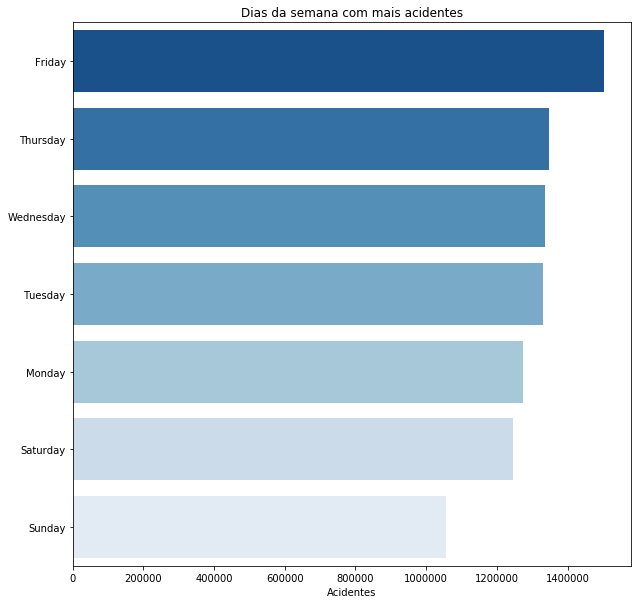

In [31]:
plt.figure(figsize=(10,10))
sns.barplot(y="dia_da_semana", x="acidentes", data=dia_semana, palette="Blues_r")
plt.title("Dias da semana com mais acidentes")
plt.ylabel(None)
plt.xlabel("Acidentes");

In [32]:
df_kill1 = df_col[["killed_victims", "injured_victims",
                  "dia_da_semana",]].groupby(by=["dia_da_semana"]).agg({"killed_victims":"sum",
                    "injured_victims":"sum"}).reset_index()
df_killk = df_kill1.sort_values(by="killed_victims", ascending=False)
df_killi = df_kill1.sort_values(by="injured_victims", ascending=False)

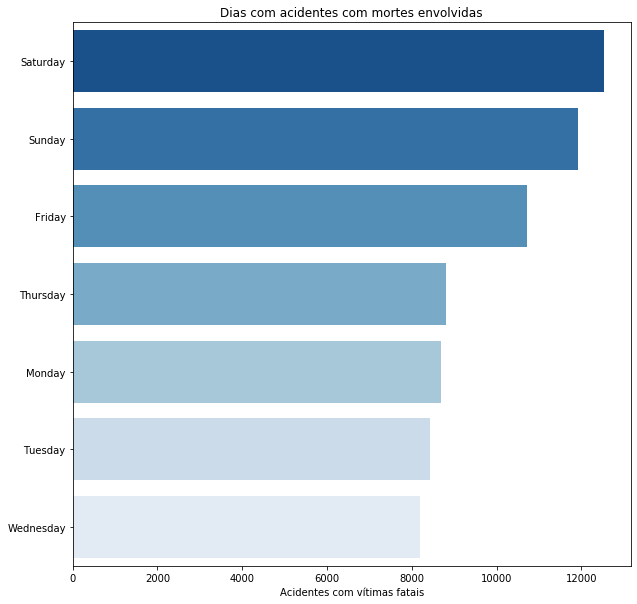

In [33]:
plt.figure(figsize=(10,10))
sns.barplot(y="dia_da_semana", x="killed_victims", data=df_killk, palette="Blues_r")
plt.title("Dias com acidentes com mortes envolvidas")
plt.ylabel(None)
plt.xlabel("Acidentes com vítimas fatais");

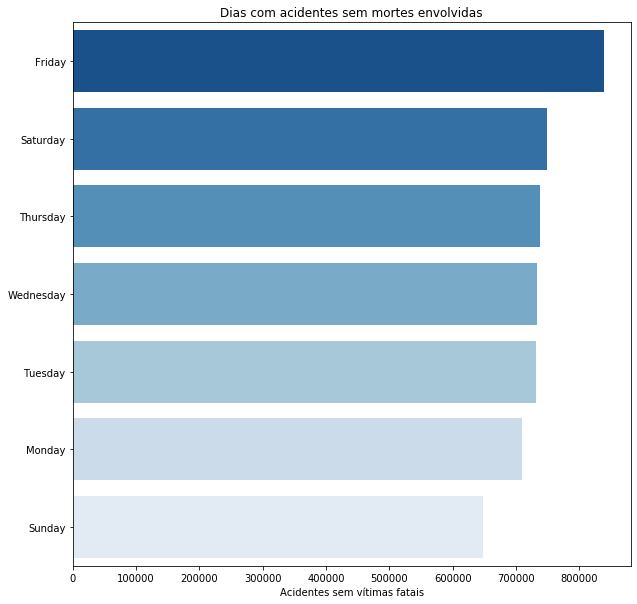

In [34]:
plt.figure(figsize=(10,10))
sns.barplot(y="dia_da_semana", x="injured_victims", data=df_killi, palette="Blues_r")
plt.title("Dias com acidentes sem mortes envolvidas")
plt.ylabel(None)
plt.xlabel("Acidentes sem vítimas fatais");

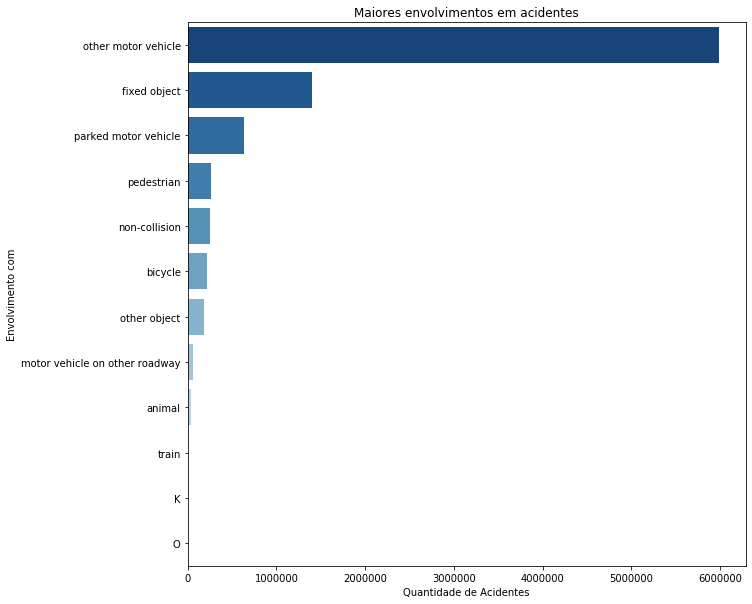

In [35]:
plt.figure(figsize=(10,10))
sns.countplot(y=df_col["motor_vehicle_involved_with"], data=df_col,
              order=df_col["motor_vehicle_involved_with"].value_counts().index, palette="Blues_r")
plt.title("Maiores envolvimentos em acidentes")
plt.ylabel("Envolvimento com")
plt.xlabel("Quantidade de Acidentes");

In [36]:
query_coli_part1 = """SELECT c.case_id, c.motor_vehicle_involved_with, c.killed_victims, 
                   p.party_type, p.vehicle_year, p.vehicle_make 
                   FROM collisions as c INNER JOIN parties as p ON c.case_id = p.case_id
                   WHERE (c.killed_victims > 0) and (c.motor_vehicle_involved_with='other motor vehicle')
"""

In [37]:
def gerar_join(query):
    starttime = timeit.default_timer()
    df_join = pd.read_sql_query(query, con)
    endtime = timeit.default_timer()
    tempo_total = round((endtime - starttime),2)

    print(f"Tempo total de execução foi de: {tempo_total}s")
    return df_join

In [38]:
df_join_col_part = gerar_join(query_coli_part1)

Tempo total de execução foi de: 324.21s


In [39]:
df_join_col_part.head()

,case_id,motor_vehicle_involved_with,killed_victims,party_type,vehicle_year,vehicle_make
0,3515353,other motor vehicle,1,driver,1998.0,HONDA
1,3515353,other motor vehicle,1,driver,2007.0,HONDA
2,3520425,other motor vehicle,1,driver,1999.0,HONDA
3,3520425,other motor vehicle,1,driver,2007.0,AUDI
4,3520437,other motor vehicle,1,driver,2005.0,TOYOTA


<Figure size 720x720 with 0 Axes>

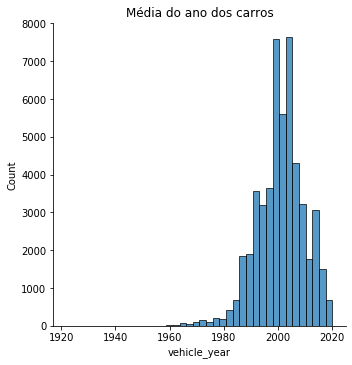

In [40]:
plt.figure(figsize=(10,10));
sns.displot(df_join_col_part, x="vehicle_year", bins=40);
plt.title("Média do ano dos carros");

In [41]:
marcas = df_join_col_part[["vehicle_make", "vehicle_year",
                  "killed_victims"]].groupby("vehicle_make").agg({'killed_victims':"sum",
                                                                  'vehicle_year':"mean"}).reset_index()
marcas.columns = ["vehicle_make","sum_victms", "mean_car_year"]
marcas = marcas.sort_values(by="sum_victms", ascending=False)
marcas = marcas.head(10)

In [42]:
marcas

,vehicle_make,sum_victms,mean_car_year
80,FORD,8497,1999.705765
338,TOYOTA,6386,2000.190929
128,HONDA,5833,1999.821364
47,CHEVROLET,5472,1998.044454
237,NISSAN,2627,2001.349213
68,DODGE,2601,2000.788101
106,GMC,1646,2000.253500
88,FREIGHTLINER,1318,2000.838448
117,HARLEY-DAVIDSON,1018,2002.720881
26,BMW,930,2002.607317


Text(0.5, 0, 'Vítimas')

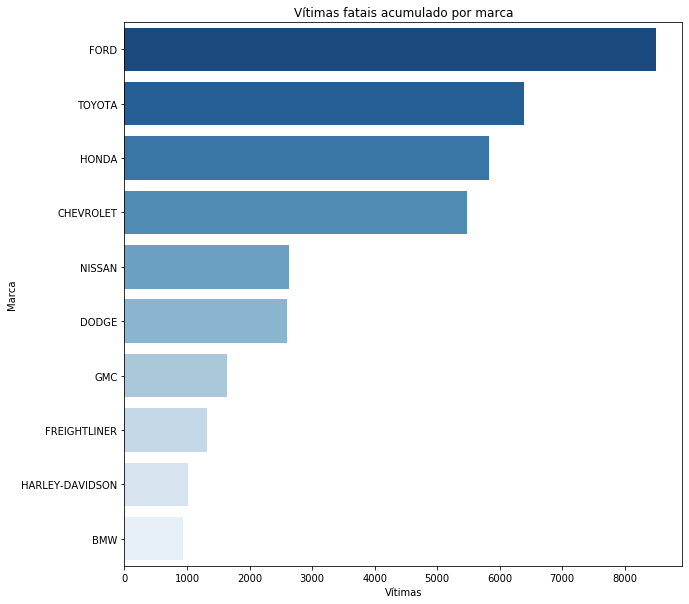

In [43]:
plt.figure(figsize=(10,10))
sns.barplot(y="vehicle_make", x='sum_victms', data=marcas, palette="Blues_r")
plt.title("Vítimas fatais acumulado por marca")
plt.ylabel("Marca")
plt.xlabel("Vítimas")